# Match truth and object catalogs for DC2 Run 2.2i
Owner: Yao-Yuan Mao, Scott Daniel (with help from Anže Slosar, Bhairav Valera, HyeYun Park) <br>
Updated by: Javier Sanchez <br>
Last Verified to Run: 2020-06-22

**Notes:**
- Follow this [step-by-step guide](https://confluence.slac.stanford.edu/x/Xgg4Dg) if you don't know how to run this notebook.
- If you need more information about the Generic Catalog Reader (GCR), see [this diagram](https://github.com/yymao/generic-catalog-reader/blob/master/README.md#concept) and [more examples](https://github.com/LSSTDESC/gcr-catalogs/blob/master/examples/GCRCatalogs%20Demo.ipynb).

## Learning objectives
After completing and studying this Notebook, you should be able to:
  1. Use GCR to load object catalog and truth catalog
  2. Use `filters` and `native_filters` appropriately
  3. Use `add_quantity_modifier` and `get_quantity_modifier`
  4. Use `FoFCatalogMatching` to do Friends-of-friends catalog matching
  5. Learn some cool Numpy tricks for binning, masking, and reshaping [Advanced]
  6. Learn use pandas to match truth catalog object id back to the galaxy id in extragalactic catalog [advanced]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
%matplotlib inline

In [2]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs
import fitsio

In [3]:
# load object catalog (for a single tract)
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6a')

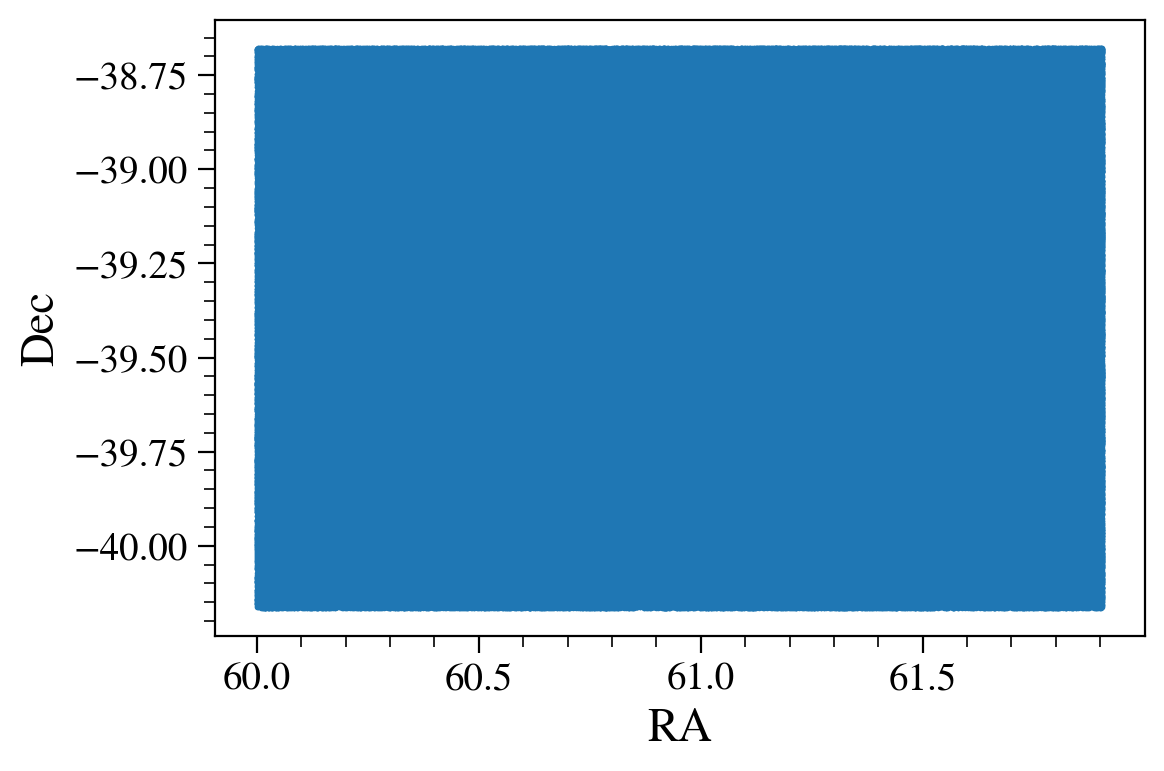

In [4]:
# Let's first visually inspect the footprint of one tract of the object catalog.
# When `return_iterator` is turned on, the method `get_quantities` will return an 
# iterator, and each element in the iterator will be the quantities we requested in 
# different chunks of the dataset. 

# For object catalogs, the different chunks happen to be different patches, 
# resulting in a different color for each patch in the scatter plot below.

for object_data in object_cat.get_quantities(['ra', 'dec'], native_filters=['tract == 3447'], return_iterator=True):
    plt.scatter(object_data['ra'], object_data['dec'], s=1, rasterized=True);

plt.xlabel('RA');
plt.ylabel('Dec');

In [5]:
# Let's also define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 24.5',
]

In [6]:
# let's add total ellipticity for later use (not needed for now)
object_cat.add_derived_quantity('shape_hsm_regauss_etot', np.hypot, 
                                'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2')

In [7]:
# Load ra and dec from object, using both of the filters we just defined.
object_data = object_cat.get_quantities(['ra', 'dec', 'mag_i_cModel', 'shape_hsm_regauss_etot',
                                         'extendedness', 'blendedness'],
                                        filters=(mag_filters), native_filters=['tract == 3447'])

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [8]:
# Let's now turn to the truth catalog. Here we just append galaxies and stars; 
# however, truth catalogs are also available in GCRCatalogs and PostgreSQL.
truth_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [9]:
# Load the stars
stars_cat = fitsio.read('/global/cfs/projectdirs/lsst/groups/SSim/DC2/all_stars_DC2_run2.1i.fits.gz')

In [10]:
max_ra = np.nanmax(object_data['ra'])
min_ra = np.nanmin(object_data['ra'])
max_dec = np.nanmax(object_data['dec'])
min_dec = np.nanmin(object_data['dec'])
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

In [11]:
# get ra and dec from truth catalog
# note that we add i < 25 to the native filter to speed up load time
truth_mag_filters = ['mag_i < 24.7']
quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift']
truth_data = truth_cat.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

In [12]:
mask_stars = (stars_cat['ra'] >= min_ra) & (stars_cat['ra'] <= max_ra) & \
             (stars_cat['decl'] >= min_dec) & (stars_cat['decl'] <= max_dec)
stars_cat = stars_cat[mask_stars] # Filter out the stars that are out of the footprint

In [13]:
total_galaxies = len(truth_data['ra'])
total_objs = len(stars_cat)+total_galaxies # Total length of the output catalog
truth_data_all = dict()
out_qty = ['id', 'ra', 'dec', 'mag_i', 'redshift']
star_qty = ['simobjid', 'ra', 'decl', 'imag', 'redshift']
out_dtype = [np.long, np.float, np.float, np.float, np.float]

In [14]:
# Allocate the columns of the dictionary
for i, dtype in enumerate(out_dtype):
    truth_data_all[out_qty[i]] = np.zeros(total_objs, dtype=dtype)
    truth_data_all[out_qty[i]][:total_galaxies] = truth_data[quantities[i]]
    if 'redshift' not in star_qty[i]:
        truth_data_all[out_qty[i]][total_galaxies:] = stars_cat[star_qty[i]] # We add the info from stars and put all stars at redshift=0
truth_data_all['star'] = np.zeros(total_objs, dtype=np.bool)
truth_data_all['star'][total_galaxies:] = True

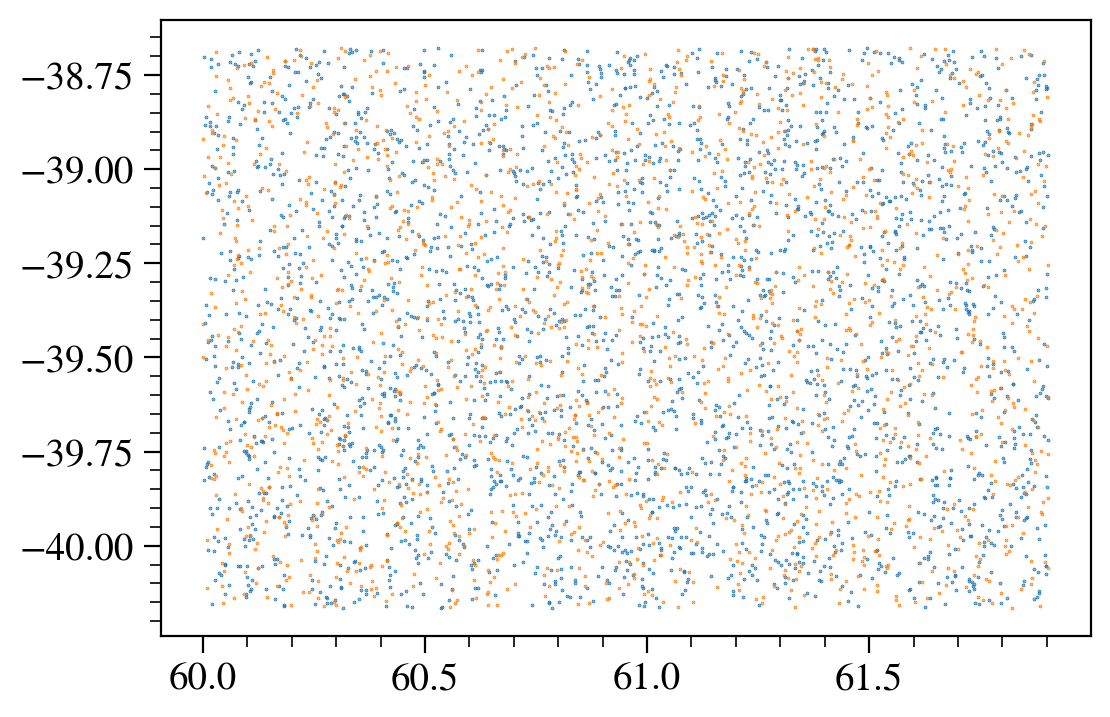

In [15]:
plt.scatter(truth_data_all['ra'][::100], truth_data_all['dec'][::100], s=0.1)
plt.scatter(object_data['ra'][::100], object_data['dec'][::100], s=0.1)

In [16]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data_all, 'object': object_data},
    linking_lengths=1.0, # Linking length of 1 arcsecond, you can play around with the values!
    catalog_len_getter=lambda x: len(x['ra']),
)

[]


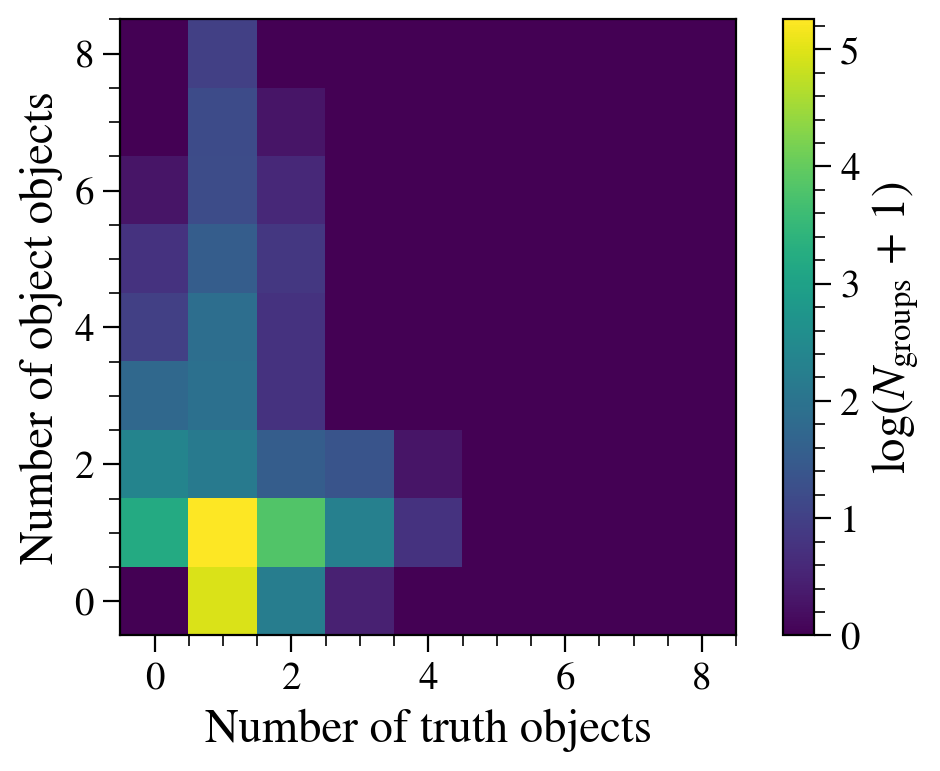

In [17]:
# now we want to count the number of truth and object objects *for each group*
# but instead of looping over groups, we can do this in a smart (and very fast) way

# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
print(n_truth[n_truth>10])
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

# now n_truth and n_object are the number of truth/object objects in each group
# we want to make a 2d histrogram of (n_truth, n_object). 
n_max = max(n_truth.max(), n_object.max()) + 1
hist_2d = np.bincount(n_object * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of truth objects');
plt.ylabel('Number of object objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [18]:
# Let's further inspect the objects in the groups that have 1-to-1 truth/object match.

# first, let's find our the IDs of the groups that have 1-to-1 truth/object match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

# and then we can find the row indices in the *original* truth/object catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

In [19]:
truth_sc = SkyCoord(truth_data_all['ra'][truth_idx], truth_data_all['dec'][truth_idx], unit="deg")
object_sc = SkyCoord(object_data['ra'][object_idx], object_data['dec'][object_idx], unit="deg")

delta_ra = (object_sc.ra.arcsec - truth_sc.ra.arcsec) * np.cos(np.deg2rad(0.5*(truth_sc.dec.deg + object_sc.dec.deg)))
delta_dec = object_sc.dec.arcsec - truth_sc.dec.arcsec
delta_arcsec = object_sc.separation(truth_sc).arcsec

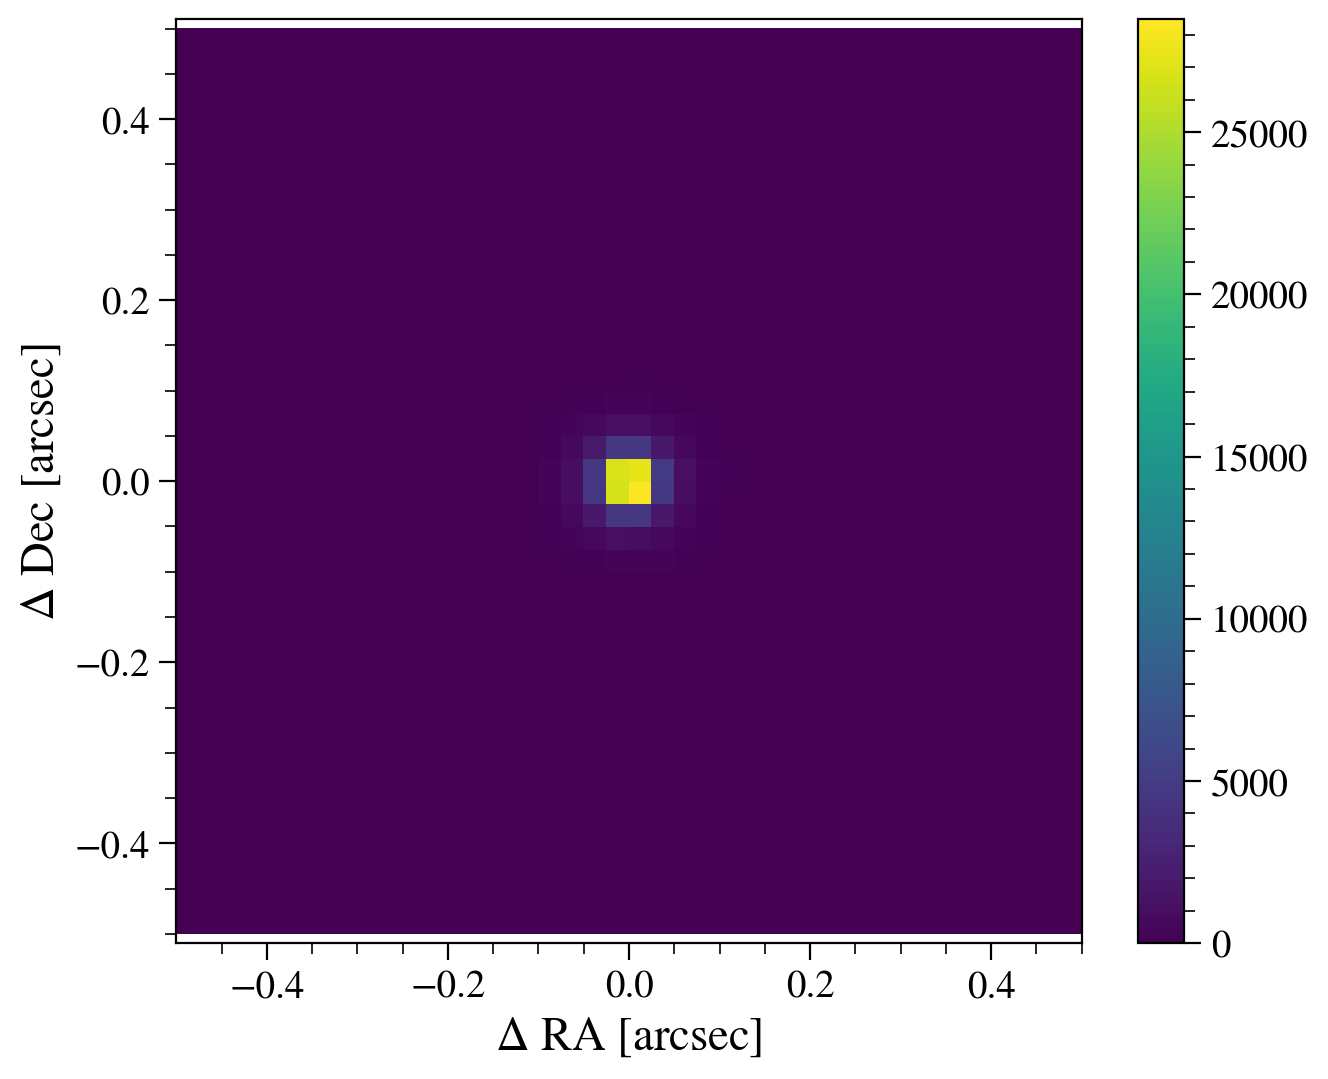

In [20]:
plt.figure(figsize=(7.3, 6))  # Pick a figuresize that will result in a square equal-axis plus colorbar
plt.hist2d(delta_ra, delta_dec, bins=40, range=((-0.5, +0.5), (-0.5, +0.5)));
plt.xlabel(r'$\Delta$ RA [arcsec]');
plt.ylabel(r'$\Delta$ Dec [arcsec]');
plt.colorbar();
plt.xlim(-0.5, +0.5)
plt.ylim(-0.5, +0.5)
plt.axis('equal');

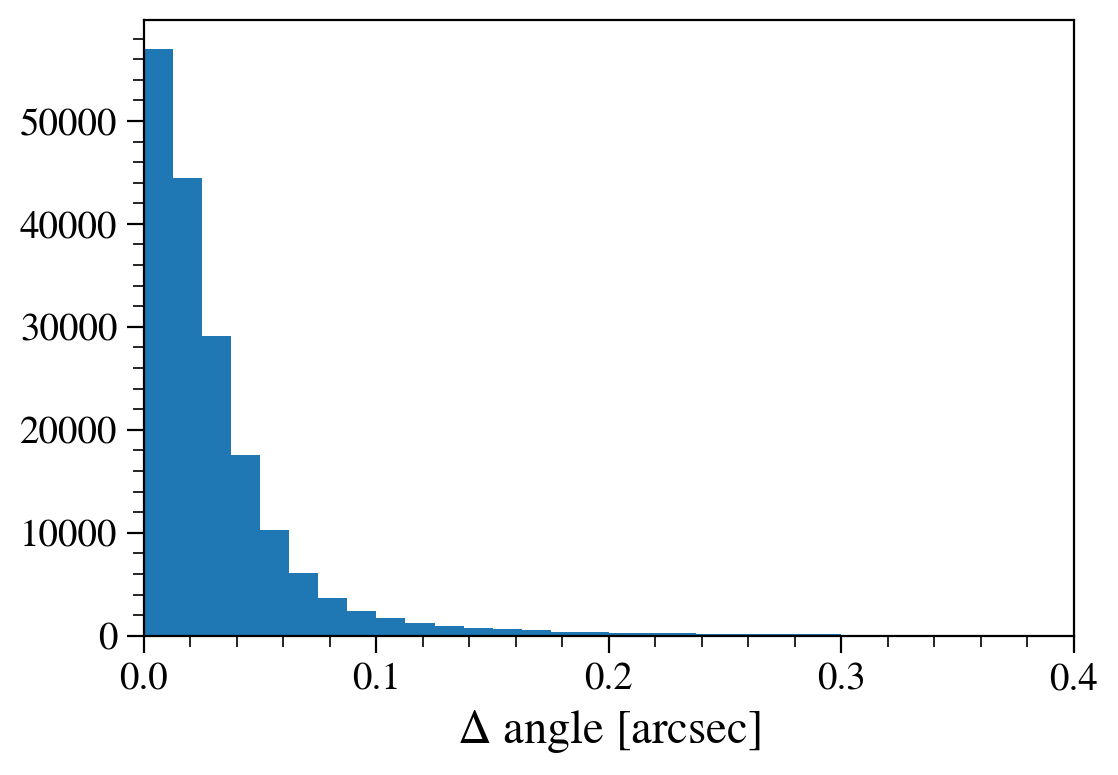

In [21]:
#Plotting Delta angle for the outputs
plt.hist(delta_arcsec, bins=80);
plt.xlim(0, 0.4);
plt.xlabel(r'$\Delta$ angle [arcsec]');

In [22]:
import pandas as pd

In [23]:
# convert truth_data and object_data to pandas dataframe and select the matched one
truth_matched = pd.DataFrame(truth_data_all).iloc[truth_idx].reset_index(drop=True)
object_matched = pd.DataFrame(object_data).iloc[object_idx].reset_index(drop=True)
matched = pd.merge(truth_matched, object_matched, left_index=True, right_index=True, suffixes=('_truth', '_object'))

In [24]:
# Select only those truth objects that are galaxies which were not sprinkled
# (stars and sprinkled objects do not occur in the extragalactic catalog)
matched_gals = matched.query('~star')

In [25]:
# load redshift and ellipticity from the extragalactic catalog, only for galaxies that are already in `matched_gals`
extragalactic_data = truth_cat.get_quantities(
    ['galaxy_id', 'mag_i_lsst', 'ellipticity_true'],
    filters=[(lambda x: np.in1d(x, matched_gals['id'].values, True), 'galaxy_id')]+truth_mag_filters+pos_filters,
    native_filters=native_filter
)

In [26]:
# merge extragalactic_data to matched_gals
matched_gals = pd.merge(matched_gals, pd.DataFrame(extragalactic_data), 'left', left_on='id', right_on='galaxy_id')

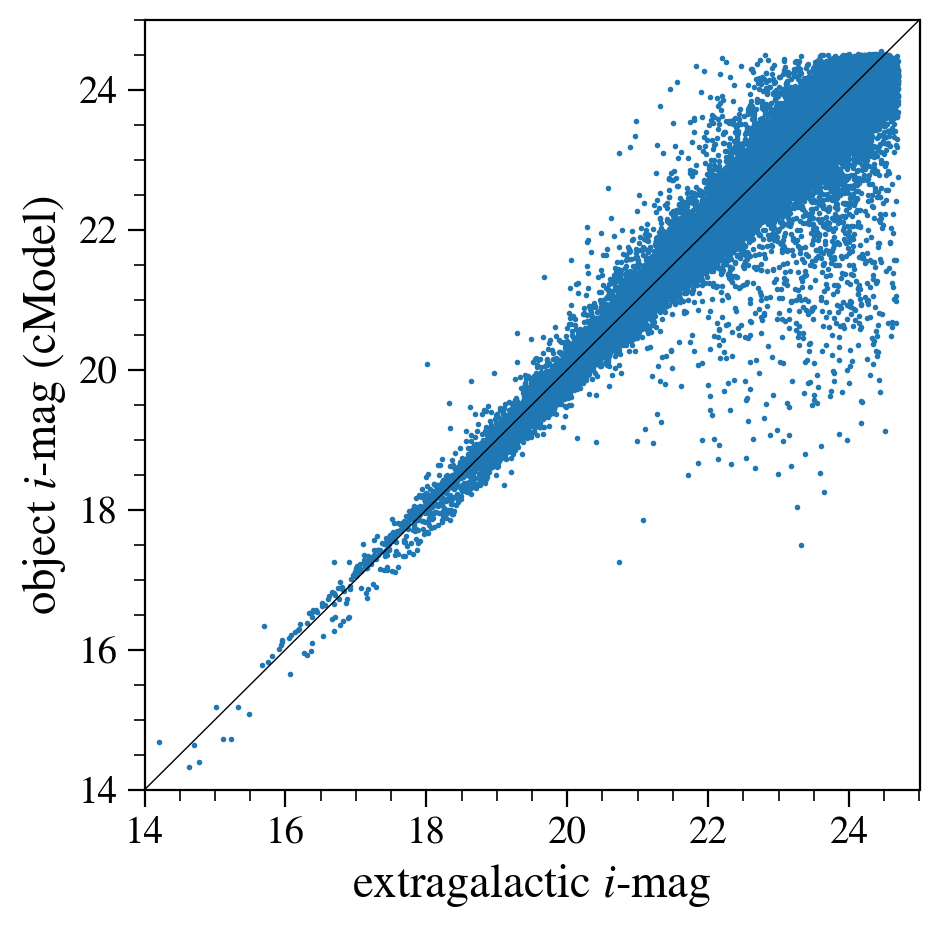

In [27]:
# compare the magnitude
plt.figure(figsize=(5,5));
plt.scatter(matched_gals['mag_i_lsst'], matched_gals['mag_i_cModel'], s=1);
lims = [14, 25]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic $i$-mag');
plt.ylabel('object $i$-mag (cModel)');
plt.xlim(lims);
plt.ylim(lims);

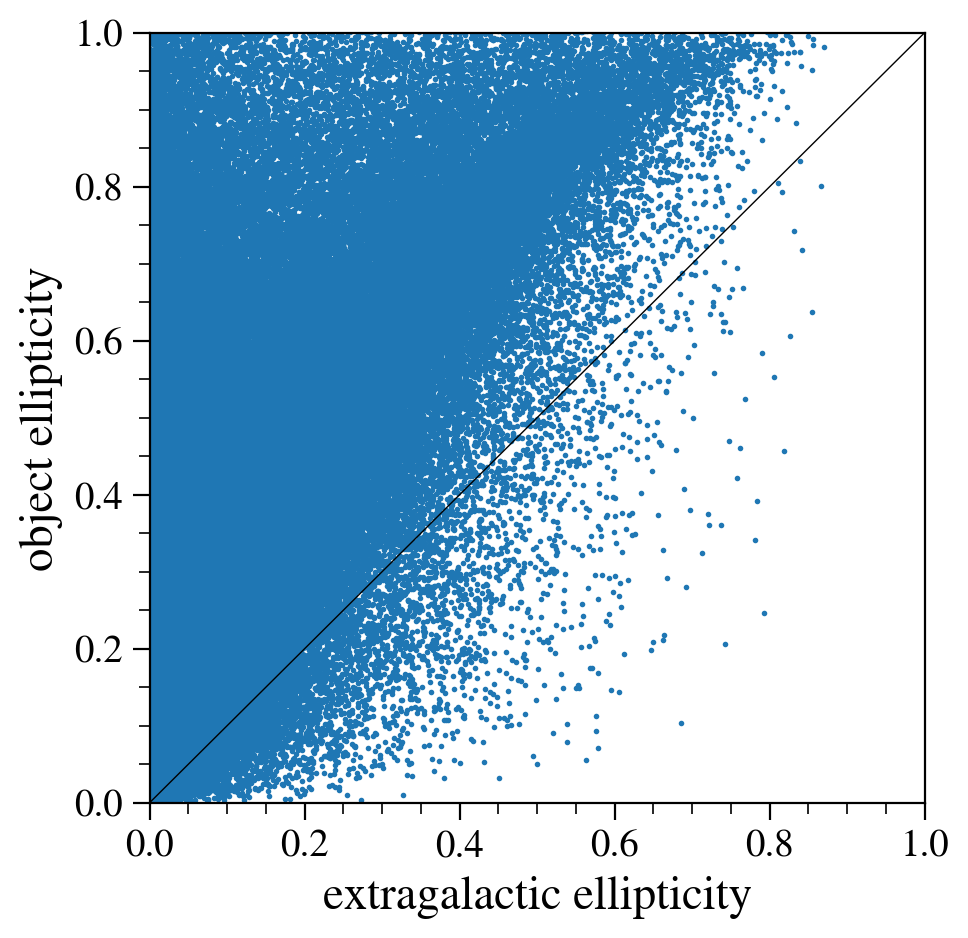

In [28]:
# compare the ellipticity (naively -- see below for further discussion)
plt.figure(figsize=(5,5));
plt.scatter(matched_gals['ellipticity_true'], matched_gals['shape_hsm_regauss_etot'], s=1);
lims = [0, 1]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic ellipticity');
plt.ylabel('object ellipticity');
plt.xlim(lims);
plt.ylim(lims);

The ellipticity comparison plot above is quite surprising. 
It seems that the ellipticities in the object catalog are generally higher (i.e., less round) than those in the extragalactic catalog. 

The quantity `shape_hsm_regauss_etot` that we used for the object catalog are the re-Gaussianization shapes, which are PSF corrected, and they could be either rounder (if the correction was an under-correction) or less round (if the correction was an over-correction). Hence, their value being systematically larger than the "truth" from extragalactic catalog seems problematic. 

Before we panic, we should, however, remind ourselves of the definition of ellipticities used in these catalogs. 
For the extragalactic catalog, ellipticity is defined as $(1-q)/(1+q)$, where $q$ is the minor-to-major axis ratio
(see the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)). 
On the other hand, for the object catalog, the HSM re-Gaussianization ellipticity that we are using is defined as $(1-q^2)/(1+q^2)$
(see e.g., Eq. 8 of [Mandelbaum et al. 2006](https://arxiv.org/abs/astro-ph/0511164)).

Hence their definitions are in fact different, so we need to do a conversion before we compare them.
With some math, we can find the conversion between the two definitions $e_{\rm HSM~def} = \frac{2e_{\rm EGC~def}}{1+e_{\rm EGC~def}^2}$.

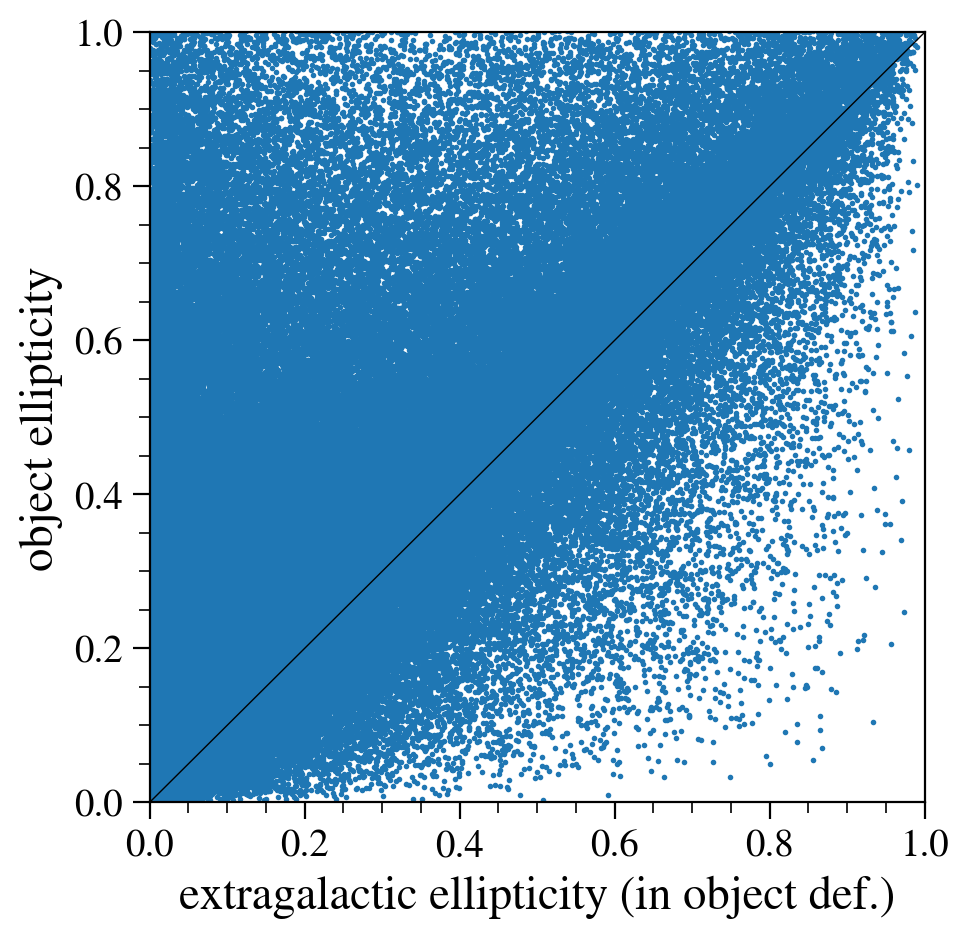

In [29]:
# compare the ellipticity (smartly)
ellipticity_conversion = lambda e: 2*e / (1.0+e*e)
plt.figure(figsize=(5,5));
plt.scatter(ellipticity_conversion(matched_gals['ellipticity_true']), matched_gals['shape_hsm_regauss_etot'], s=1);
lims = [0, 1]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic ellipticity (in object def.)');
plt.ylabel('object ellipticity');
plt.xlim(lims);
plt.ylim(lims);

This looks much better now! 

When you were checking the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)) file,
you probably have also noticed that `ellipticity_true` is the ellipticity before the shear is applied (i.e., unlensed). 
Hence this comparison is still not an apples-to-apples comparison, as the ellipticity in the object catalog is, of course, lensed. 

According to the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)), we should have been using `ellipticity` from the extragalactic catalog.
But unfortunately, this quantity is not directly available from the extragalactic catalog!

In [30]:
def calc_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es = es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.absolute(e)
    
truth_cat.add_derived_quantity('ellipticity', calc_lensed_ellipticity, 
                                       'ellipticity_1_true', 'ellipticity_2_true', 'shear_1', 'shear_2', 'convergence')

In [31]:
# Now let's get the newly defined ellipticity and add to our merged pandas data frame:
extragalactic_data_more = truth_cat.get_quantities(
    ['galaxy_id', 'ellipticity'],
    filters=[(lambda x: np.in1d(x, matched_gals['id'].values, True), 'galaxy_id')], native_filters=native_filter
)

matched_gals = pd.merge(matched_gals, pd.DataFrame(extragalactic_data_more), 'left', left_on='id', right_on='galaxy_id')

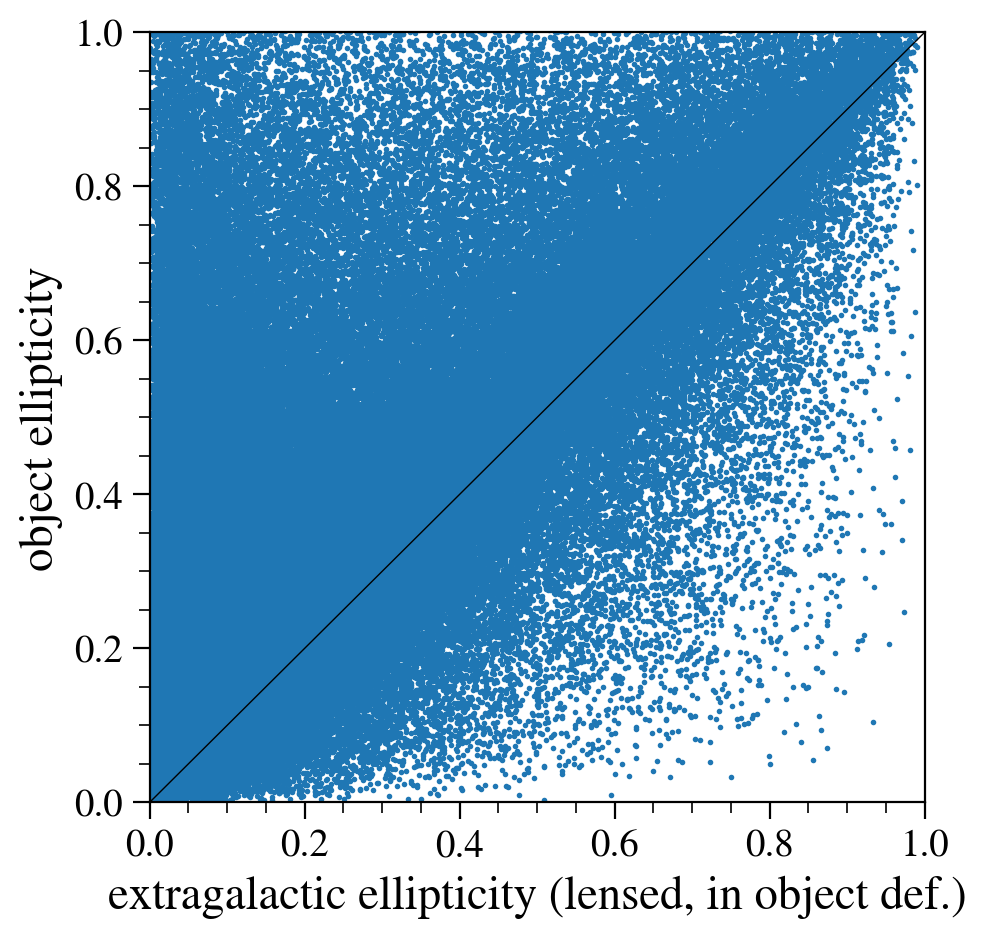

In [32]:
# Now we compare the ellipticity again (and don't forget the definition conversion!)
ellipticity_conversion = lambda e: 2*e / (1.0+e*e)
plt.figure(figsize=(5,5));
plt.scatter(ellipticity_conversion(matched_gals['ellipticity']), matched_gals['shape_hsm_regauss_etot'], s=1);
lims = [0, 1]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic ellipticity (lensed, in object def.)');
plt.ylabel('object ellipticity');
plt.xlim(lims);
plt.ylim(lims);